<a href="https://colab.research.google.com/github/MiguelCarbo/Anomalies-Detection-TFG/blob/main/v2_PYOD_Anomalies_795802.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Reset Variables
%reset

In [ ]:
#from google.colab import files
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from tabulate import tabulate
from sklearn.tree import plot_tree, export_graphviz
import graphviz 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,f_classif
import plotly.express as px
import glob
import json

In [ ]:
# Python Outlier Detection + Zeek Analysis Tool
!pip install pyod
!pip install zat

# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.ecod import ECOD
from pyod.models.copod import COPOD

# Local Imports
import zat;
from zat.log_to_dataframe import LogToDataFrame;
from zat.dataframe_to_matrix import DataFrameToMatrix;

# Packet Imports
import pandas as pd;
import numpy as np;
import sklearn;
from sklearn.ensemble import IsolationForest;
from sklearn.decomposition import PCA;
from sklearn.cluster import KMeans, DBSCAN;
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager

# Version Printing
print('zat: {:s}'.format(zat.__version__))
print('Pandas: {:s}'.format(pd.__version__))
print('Numpy: {:s}'.format(np.__version__))
print('Scikit Learn Version:', sklearn.__version__)
# print('PYOD Version: {:s}'.format(pyod.__version__))

### 1. DATAFRAME CREATION FROM ZEEK LOG ###

In [ ]:
# Create a Pandas dataframe from the Zeek log
log_to_df = LogToDataFrame();
conn_df = log_to_df.create_dataframe('conn.log');
print('Read in {:d} Rows...'.format(len(conn_df)))
conn_df.columns

### 2. FEATURE SELECTION ###

In [3]:
full_features = ['sourceAddress', 'sourcePort', 'destinationAddress', 'destinationPort', 'uid', 'protocol', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents',
        'mediaOrigen', 'mediaResp','desvOrigen', 'desvResp', 'noceroOrigen', 'noceroResp', 'mediaTime', 'desvTime']

features = ['service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'history',
            'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents',
        'mediaOrigen', 'mediaResp','desvOrigen', 'desvResp', 'noceroOrigen', 'noceroResp', 'mediaTime', 'desvTime']

### 3. DATA PREPARATION ###

#### 3.1 DATA CLEANSING ####

In [4]:
# Feature Filtering + NaNs removal
conn_df = conn_df[full_features]
conn_df = conn_df.dropna()
conn_features_df = conn_df[features]

In [ ]:
# Additional data preparation
for feature in features:
    if (conn_features_df[feature].dtype.name == 'category') and ('0' not in conn_features_df[feature].cat.categories):
        conn_features_df[feature] = conn_features_df[feature].cat.add_categories(['0'])
        conn_features_df[feature] = conn_features_df[feature].fillna('0')
    elif pd.api.types.is_timedelta64_dtype(conn_features_df[feature]): 
        conn_features_df[feature] = conn_features_df[feature].fillna(pd.Timedelta(0))
        conn_features_df[feature] = conn_features_df[feature].dt.total_seconds().astype(int)
    else: 
        conn_features_df[feature] = conn_features_df[feature].fillna(0)

#### 3.2 LABEL ENCODING ####

In [ ]:
# Relevant Considerations
# -- The ABOD (Angle-based Outlier Detection) algorithm is a distance-based outlier 
# -- detection algorithm that measures the angles between points in a high-dimensional space to detect outliers. 

# -- As a distance-based algorithm, it requires that all input features be numeric, as it relies on computing distances between points in the feature space.
# -- If your data contains non-numeric features, such as string values in some columns, then the ABOD algorithm will not be able to compute distances correctly 
# -- and will not be able to fit the data. This is normal behavior for distance-based algorithms like ABOD.

# -- To use the ABOD algorithm on your data, you will need to preprocess your data to convert the string features into numeric ones. 
# -- There are several ways to do this, depending on the specific characteristics of your data. One common approach is to use one-hot encoding or 
# -- label encoding to convert categorical features into numerical features that can be used by the algorithm.

# -- Alternatively, you may consider using a different outlier detection algorithm that can handle mixed data types, 
# -- such as the Isolation Forest algorithm or the Local Outlier Factor algorithm. These algorithms can handle both numeric and categorical features, 
# -- and can be used on mixed data types without requiring feature preprocessing.

In [ ]:
# LabelEncoding
# -- Another option might be using OneHotEncoding
le = LabelEncoder()
for feature in features:
    if (conn_features_df[feature].dtype.name == 'category') :
        print(feature)
        conn_features_df[feature] = le.fit_transform(conn_features_df[feature])

#### 3.3 NUMPY ARRAY CREATION ####

In [ ]:
# Dataframe conversion to float 
# - Necesario para operaciones posteriores
conn_features_df = conn_features_df.astype(float)

# Convert the dataframe to a numpy array
X = conn_features_df.to_numpy()
print(X.shape)

### 4. CLASSIFICATION ALGORITHMS ###

In [8]:
# Random State 42
# -- In NumPy, the random_state parameter is used to set the seed for the 
# -- random number generator, which determines the sequence of random numbers 
# -- generated by NumPy's random functions.

# -- When you set random_state to a fixed value, you get a reproducible sequence 
# -- of random numbers every time you run your code. 
# -- This can be useful when you need to compare results across multiple runs 
# -- or when you want to ensure that the random numbers are the same each time you run your code.

# -- In the case of random_state=42, the number 42 is an arbitrary value that 
# -- is commonly used as a default seed in many programming examples and tutorials.

rs = np.random.RandomState(42)

# Outlier detectetion algorithms
clf = {
    # 'Angle-based Outlier Detector (ABOD)': ABOD(contamination=0.1),
    # 'Cluster-based Local Outlier Factor (CBLOF)': CBLOF(contamination=0.1, check_estimator=False, random_state=rs),
    'Isolation Forest': IForest(contamination=0.1, random_state=rs),
    # 'K Nearest Neighbors (KNN)': KNN(contamination=0.1),
    # 'Average KNN': KNN(method='mean', contamination=0.1),
    # 'Local Outlier Factor (LOF)': LOF(n_neighbors=35, contamination=0.1),
    'Copula Based Outlier Detector (COPOD)': COPOD(contamination=0.1),
    'Emipirical-Cumulative-Distribution-based Outlier Detector (ECOD)': ECOD(contamination=0.1),
    # 'One-class SVM (OCSVM)': OCSVM(contamination=0.1),
}

In [9]:
# Show all detectors
for i, classifier in enumerate(clf.keys()):
    print('Model', i + 1, classifier)

Model 1 Isolation Forest
Model 2 Copula Based Outlier Detector (COPOD)
Model 3 Emipirical-Cumulative-Distribution-based Outlier Detector (ECOD)


### 5. MODEL FITTING - TRAINING - PREDICTION ###

In [10]:
clusters_separation = [0]
clf_names = list(clf.keys())
outliers_pred = np.zeros((X.shape[0], len(clf_names)))

# Fit the models with the generated data and compare model performances
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)

    # Fit the model
    for i, (classifier_name, classifier) in enumerate(clf.items()):

        print(i + 1, 'fitting', classifier_name)

        # Fit the data and tag outliers
        classifier.fit(X)

        # Scores prediction
        scores_pred = classifier.decision_function(X) * -1
        
        # Outliers detection (based on prediction)
        y_pred = classifier.predict(X)
        outliers_pred[:,i] = y_pred;

1 fitting Isolation Forest
2 fitting Copula Based Outlier Detector (COPOD)
3 fitting Emipirical-Cumulative-Distribution-based Outlier Detector (ECOD)


### 6. RESULT ANALYSIS ###

### 6.1 OUTLIERS DATAFRAMES ###

In [26]:
# New Dataframes to store each Outlier
ABOD_out_df = pd.DataFrame()
CBLOF_out_df = pd.DataFrame()
IFOREST_out_df = pd.DataFrame()
KNN_out_df = pd.DataFrame()
AKNN_out_df = pd.DataFrame()
LOF_out_df = pd.DataFrame()
ECOD_out_df = pd.DataFrame()
COPOD_out_df = pd.DataFrame()

# Outliers Stored for each algorithm
# - Se guarda en cada df las filas detectadas como 'outliers' para cada algoritmo
for i in range(outliers_pred.shape[0]):
    if outliers_pred[i,0] == 1:
        IFOREST_out_df = IFOREST_out_df.append(conn_df.iloc[i])
    if outliers_pred[i,1] == 1:
        COPOD_out_df = COPOD_out_df.append(conn_df.iloc[i])
    if outliers_pred[i,2] == 1:
        ECOD_out_df = ECOD_out_df.append(conn_df.iloc[i])

# Numeric Data Types Correction
# - Necesario porque en caso contrario, los puertos se codifican como int16 y existe overflow
IFOREST_out_df['sourcePort'] = np.uint16(IFOREST_out_df['sourcePort'])
IFOREST_out_df['destinationPort'] = np.uint16(IFOREST_out_df['destinationPort'])
COPOD_out_df['sourcePort'] = np.uint16(COPOD_out_df['sourcePort'])
COPOD_out_df['destinationPort'] = np.uint16(COPOD_out_df['destinationPort'])
ECOD_out_df['sourcePort'] = np.uint16(ECOD_out_df['sourcePort'])
ECOD_out_df['destinationPort'] = np.uint16(ECOD_out_df['destinationPort'])


### 6.2 ANOMALOUS FLOW-ID EXTRACTION ###

In [29]:
# We extract unique malign FlowID Values
# - Se extraen los FlowID -> Protocolo + IPs + Puertos para a continuación medir aciertos y errores
IFOREST_out_df['flow_id'] = IFOREST_out_df['protocol'].astype(str) + IFOREST_out_df['sourceAddress'].astype(str) + IFOREST_out_df['destinationAddress'].astype(str) + IFOREST_out_df['sourcePort'].astype(str) + IFOREST_out_df['destinationPort'].astype(str)
IFOREST_flow_id_values = IFOREST_out_df['flow_id'].unique()

COPOD_out_df['flow_id'] = COPOD_out_df['protocol'].astype(str) + COPOD_out_df['sourceAddress'].astype(str) + COPOD_out_df['destinationAddress'].astype(str) + COPOD_out_df['sourcePort'].astype(str) + COPOD_out_df['destinationPort'].astype(str)
COPOD_flow_id_values = COPOD_out_df['flow_id'].unique()

ECOD_out_df['flow_id'] = ECOD_out_df['protocol'].astype(str) + ECOD_out_df['sourceAddress'].astype(str) + ECOD_out_df['destinationAddress'].astype(str) + ECOD_out_df['sourcePort'].astype(str) + ECOD_out_df['destinationPort'].astype(str)
ECOD_flow_id_values = ECOD_out_df['flow_id'].unique()


### 6.3 ANOMALOUS UID EXTRACTION ###

In [33]:
# We extract unique malign UID Values obtained with each algorithm
IFOREST_uid_values = IFOREST_out_df['uid'].unique()
COPOD_uid_values = COPOD_out_df['uid'].unique()
ECOD_uid_values = ECOD_out_df['uid'].unique()

### 7. RESULT ANALYSIS ###

#### 7.A FROM ORIGINAL CSV ####

In [ ]:
# NOTA: esta fuente no debe ser tomada como referencia fiable puesto que los flujos
# del archivo CSV han sido etiquetados de forma errónea; se utiliza solo como una 
# medida temporal de orientación

# Original Source with Labeled Data
original_df = pd.read_csv('Tuesday-WorkingHours.pcap_ISCX.csv')
print(original_df.columns)

# Eliminamos todas las filas que tengan la columna de Benign
malign_original_df = original_df.drop(original_df[original_df[' Label'] == 'BENIGN'].index)

# Formateo del Dataframe
if (' Source IP' and ' Destination IP' and ' Source Port' and ' Destination Port') in original_df.columns:
    malign_original_df = malign_original_df.rename(columns={' Protocol': 'protocol'})
    malign_original_df = malign_original_df.rename(columns={' Source IP': 'sourceAddress'})
    malign_original_df = malign_original_df.rename(columns={' Destination IP': 'destinationAddress'})
    malign_original_df = malign_original_df.rename(columns={' Source Port': 'sourcePort'})
    malign_original_df = malign_original_df.rename(columns={' Destination Port': 'destinationPort'})

# Ajustamos los valores de la columna 'protocol'
mask_6 = malign_original_df['protocol'] == 6
mask_17 = malign_original_df['protocol'] == 17
malign_original_df.loc[mask_6, 'protocol'] = 'tcp'
malign_original_df.loc[mask_17, 'protocol'] = 'udp'

# Obtenemos los flujos malignos identificados de forma única
malign_original_df['flow_id'] = malign_original_df['protocol'].astype(str) + malign_original_df['sourceAddress'].astype(str) + malign_original_df['destinationAddress'].astype(str) + malign_original_df['sourcePort'].astype(str) + malign_original_df['destinationPort'].astype(str)
malign_flow_id_values = malign_original_df['flow_id'].unique()


In [47]:
# Positive Detection
detected_positives = 0

# Analizamos para cada algoritmo los resultados obtenidos
for i in range (0, len(clf_names)):
    if i == 0:
        for flow_id in IFOREST_flow_id_values:
            # Check if the concatenated value is in the list of ip_src_dest values
            if flow_id in malign_flow_id_values:
                detected_positives+=1
        print('- IFOREST Results -')
        print('Detected Positives:', detected_positives)
        print('False Positives: ', len(IFOREST_flow_id_values) - detected_positives)
        print('Undetected Malign:', len(malign_flow_id_values) - detected_positives)
    if i == 1:
        for flow_id in COPOD_flow_id_values:
            # Check if the concatenated value is in the list of ip_src_dest values
            if flow_id in malign_flow_id_values:
                detected_positives+=1
        print('- COPOD Results -')
        print('Detected Positives:', detected_positives)
        print('False Positives: ', len(COPOD_flow_id_values) - detected_positives)
        print('Undetected Malign:', len(malign_flow_id_values) - detected_positives)
    if i == 2:
        for flow_id in ECOD_flow_id_values:
            # Check if the concatenated value is in the list of ip_src_dest values
            if flow_id in malign_flow_id_values:
                detected_positives+=1
        print('- ECOD Results -')
        print('Detected Positives:', detected_positives)
        print('False Positives: ', len(ECOD_flow_id_values) - detected_positives)
        print('Undetected Malign:', len(malign_flow_id_values) - detected_positives)


- IFOREST Results -
Detected Positives: 47
False Positives:  29476
Undetected Malign: 6923
- COPOD Results -
Detected Positives: 202
False Positives:  29164
Undetected Malign: 6768
- ECOD Results -
Detected Positives: 2045
False Positives:  27265
Undetected Malign: 4925


#### 7.B FROM SCRIPT LABELED .LOG FILE ####

In [ ]:
# Dataframe etiquetado según el Script creado
# - Este archivo ha sido etiquetado de forma correcta 
labeled_conn_df = log_to_df.create_dataframe('conn_label.log');
malign_conn_df = labeled_conn_df[labeled_conn_df['label'] == 'MALIGN'];
malign_conn_df['flow_id'] = malign_conn_df['protocol'].astype(str) + malign_conn_df['sourceAddress'].astype(str) + malign_conn_df['destinationAddress'].astype(str) + malign_conn_df['sourcePort'].astype(str) + malign_conn_df['destinationPort'].astype(str)

In [40]:
# La detección de flujos se podrá hacer por el parámetro UID de los archivos
# generados por Zeek o por una etiqueta de 'FlowID', de forma semejante a como
# se ha hecho con el CSV

# -- Detección utilizando el valor de identificador único de flujo
# Unique Malign UID Values
malign_conn_uid_values = malign_conn_df['uid'].unique()
detected_positives = 0

print(' ')
print('-- Detected Malign UID Values --')
print(' ')

# Detected Malign UID Values
for i in range (0, len(clf_names)):
    if i == 0:
        for uid in IFOREST_uid_values:
            # Check if the concatenated value is in the list of ip_src_dest values
            if uid in malign_conn_uid_values:
                detected_positives+=1
        print('- IFOREST Results -')
        print('Detected Positives:', detected_positives)
        print('False Positives: ', len(IFOREST_uid_values) - detected_positives)
        print('Undetected Malign:', len(malign_conn_uid_values) - detected_positives)
        print(' ')

    if i == 1:
        for uid in COPOD_uid_values:
            # Check if the concatenated value is in the list of ip_src_dest values
            if uid in malign_conn_uid_values:
                detected_positives+=1
        print('- COPOD Results -')
        print('Detected Positives:', detected_positives)
        print('False Positives: ', len(COPOD_uid_values) - detected_positives)
        print('Undetected Malign:', len(malign_conn_uid_values) - detected_positives)
        print(' ')

    if i == 2:
        for uid in ECOD_uid_values:
            # Check if the concatenated value is in the list of ip_src_dest values
            if uid in malign_conn_uid_values:
                detected_positives+=1
        print('- ECOD Results -')
        print('Detected Positives:', detected_positives)
        print('False Positives: ', len(ECOD_uid_values) - detected_positives)
        print('Undetected Malign:', len(malign_conn_uid_values) - detected_positives)
        print(' ')

['CFZVoy3lZoEukTx721' 'C814KJBoSDegQVGb6' 'CbHSc929pVYbpepBa2' ...
 'Cx0tQr1vKroDrlnVn3' 'CqyPY2mOp6cW0MEog' 'CbeRPh2Mqp309v5BQb']
 
-- Detected Malign UID Values --
 
- IFOREST Results -
Detected Positives: 26
False Positives:  30312
Undetected Malign: 6375
 
- COPOD Results -
Detected Positives: 120
False Positives:  30218
Undetected Malign: 6281
 
- ECOD Results -
Detected Positives: 1904
False Positives:  28434
Undetected Malign: 4497
 


In [42]:
# -- Detección utilzando el valor de 'FlowID'
# Unique Malign FlowID Values
malign_conn_df['flow_id'] = malign_conn_df['protocol'].astype(str) + malign_conn_df['sourceAddress'].astype(str) + malign_conn_df['destinationAddress'].astype(str) + malign_conn_df['sourcePort'].astype(str) + malign_conn_df['destinationPort'].astype(str)
malign_conn_flow_id_values = malign_conn_df['flow_id'].unique()
detected_positives = 0

print(' ')
print('-- Detected Malign Flow id Values --')
print(' ')

# Detected Malign FlowID Values
for i in range (0, len(clf_names)):
    if i == 0:
        for flow_id in IFOREST_flow_id_values:
            # Check if the concatenated value is in the list of ip_src_dest values
            if flow_id in malign_conn_flow_id_values:
                detected_positives+=1
        print('- IFOREST Results -')
        print('Detected Positives:', detected_positives)
        print('False Positives: ', len(IFOREST_flow_id_values) - detected_positives)
        print('Undetected Malign:', len(malign_conn_flow_id_values) - detected_positives)
        print(' ')

    if i == 1:
        for flow_id in COPOD_flow_id_values:
            # Check if the concatenated value is in the list of ip_src_dest values
            if flow_id in malign_conn_flow_id_values:
                detected_positives+=1
        print('- COPOD Results -')
        print('Detected Positives:', detected_positives)
        print('False Positives: ', len(COPOD_flow_id_values) - detected_positives)
        print('Undetected Malign:', len(malign_conn_flow_id_values) - detected_positives)
        print(' ')

    if i == 2:
        for flow_id in ECOD_flow_id_values:
            # Check if the concatenated value is in the list of ip_src_dest values
            if flow_id in malign_conn_flow_id_values:
                detected_positives+=1
        print('- ECOD Results -')
        print('Detected Positives:', detected_positives)
        print('False Positives: ', len(ECOD_flow_id_values) - detected_positives)
        print('Undetected Malign:', len(malign_conn_flow_id_values) - detected_positives)
        print(' ')


<ipython-input-42-63031f45e141>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  malign_conn_df['flow_id'] = malign_conn_df['protocol'].astype(str) + malign_conn_df['sourceAddress'].astype(str) + malign_conn_df['destinationAddress'].astype(str) + malign_conn_df['sourcePort'].astype(str) + malign_conn_df['destinationPort'].astype(str)


 
-- Detected Malign Flow id Values --
 
- IFOREST Results -
Detected Positives: 26
False Positives:  29497
Undetected Malign: 6375
 
- COPOD Results -
Detected Positives: 120
False Positives:  29246
Undetected Malign: 6281
 
- ECOD Results -
Detected Positives: 1904
False Positives:  27406
Undetected Malign: 4497
 


### PRUEBA DE CLUSTERING - PROYECCION TSNE ###

In [ ]:
to_matrix = DataFrameToMatrix();
conn_feature_matrix = to_matrix.fit_transform(conn_features_df, normalize=True);
conn_feature_matrix.shape

# Now try DBScan
conn_features_df['cluster_db'] = DBSCAN().fit_predict(conn_feature_matrix)
print('Number of Clusters: {:d}'.format(conn_df['cluster_db'].nunique()))

Normalizing column service...
Normalizing column duration...
Normalizing column orig_bytes...
Normalizing column resp_bytes...
Normalizing column conn_state...
Normalizing column history...
Normalizing column orig_pkts...
Normalizing column orig_ip_bytes...
Normalizing column resp_pkts...
Normalizing column resp_ip_bytes...
Normalizing column tunnel_parents...
Cannot normalize series (div by 0) so not normalizing...
Normalizing column mediaOrigen...
Normalizing column mediaResp...
Normalizing column desvOrigen...
Normalizing column desvResp...
Normalizing column noceroOrigen...
Normalizing column noceroResp...
Normalizing column mediaTime...
Normalizing column desvTime...


In [ ]:
# Now use dataframe group by cluster
cluster_groups_db = conn_df.groupby('cluster_db')

# Projection using TSNE or PCA algorithm
projection = TSNE().fit_transform(conn_feature_matrix);

conn_df['x'] = projection[:, 0]; # Projection X Column
conn_df['y'] = projection[:, 1]; # Projection Y Column


colors = {-1:'green', 0:'blue', 2:'yellow'}

# Plot the Machine Learning results
fig, ax = plt.subplots()
for key, group in cluster_groups_db:
    group.plot(ax=ax, kind='scatter', x='x', y='y', alpha=0.5, s=250,
               label='Cluster_DB: {:d}'.format(key), color=colors[key])

In [ ]:
# Now print out the details for each cluster
pd.set_option('display.width', 1000)
for key, group in cluster_groups:
    print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
    print(group[features].head())

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ValueError: ignored

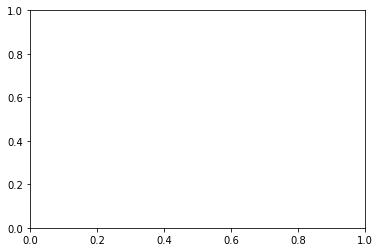

In [15]:
#X = conn_df.drop('uid', axis=1) # Replace 'label_column' with the name of the column containing the labels
#X = X.drop('sourceAddress', axis=1)
#X = X.drop('sourcePort', axis=1)
#X = X.drop('destinationAddress', axis=1)
#X = X.drop('destinationPort', axis=1)

X = conn_features_df
rows_to_drop = int(len(X) * 0.75)
X = X.iloc[rows_to_drop:]
y = conn_df['uid']

# Initialize the t-SNE algorithm with the desired parameters
tsne = TSNE(n_components=2, random_state=42)

# Apply t-SNE to the features
X_tsne = tsne.fit_transform(X)

# Visualize the t-SNE projection in a scatter plot
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('t-SNE projection')
plt.show()

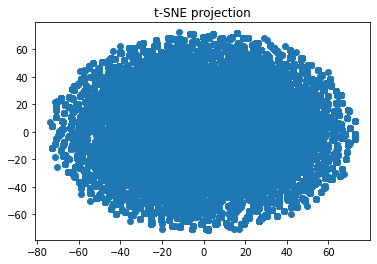

In [16]:

# Visualize the t-SNE projection in a scatter plot
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('t-SNE projection')
plt.show()